# Introduction

The temperature measurement is done with the following circuit:

![](schematic-sensor.png)

The value of the thermistor is defined as $ R_T=R_N \cdot e^{B \cdot \left(\frac{1}{T} - \frac{1}{T_N}\right)} $ with $ T_N = 298.15 $. 

This results in: $ T = \frac{B \cdot T_N}{B + \ln\left( \frac{R_T}{R_N} \right) \cdot T_N} $

*Please note: Temperature values must be given in Kelvin.*

Based on the following equations:
$$
\begin{align}
U_4 &= U_3 + U_1 + U_2 \\
V_{CC} &= U_{R_T} + U_4 \\
I &= I_3 + I_4
\end{align}
$$

and
$$
\frac{V_{CC}-U_4}{U_4} = \frac{R_T}{R_4 \parallel (R_1+R_2+R_3)}
$$

In [59]:
from IPython.display import Markdown as md
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [519]:
pt1000 = np.array([[-20, -15, -10, -5, 0,5,10,15,20,25,30],[8194, 6256, 4825, 3758, 2954, 2342,1872,1508,1224,1000,823]])
R_N = 1000
T_N = 298.15

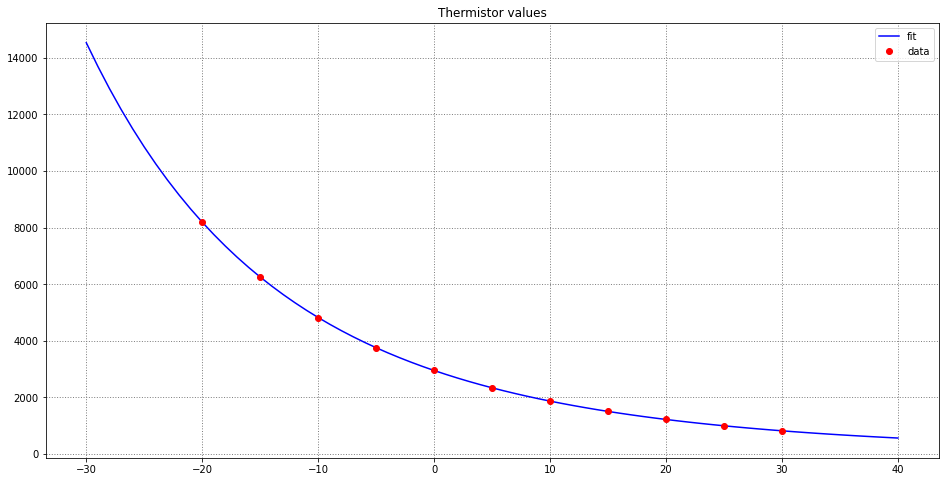

In [540]:
def func(T, B):
    return R_N * np.exp(B*(1/T - 1/T_N)) 

popt, pcov = curve_fit(func, pt1000[0]+273.15, pt1000[1])
x_data = np.arange(-30, 41, 1)
y_data = func(x_data+273.15, *popt)

plt.plot(x_data, y_data, 'b-', label='fit')

stdevs = np.sqrt(np.diag(pcov))

plt.plot(pt1000[0], pt1000[1], 'ro', label='data')
plt.legend()
plt.rcParams['figure.figsize'] = [16,8]
plt.grid(color='grey', linestyle=':', linewidth=1)
plt.title('Thermistor values');

In [543]:
md("Based on model data we get $B={:.2f} \pm {:.2f}$.".format(popt[0], stdevs[0]))

Based on model data we get $B=3528.01 \pm 0.04$.

## Calculating the temperature

To actually calculate the current temperature from a given ADC-value we need to

1. get a general idea what the formula looks like
2. sample data

In [582]:
raw = np.array([787, 780, 773, 754, 749, 729, 717, 722, 725, 731.3, 746.6, 754.9, 763.7, 748.7, 742.5, 715.6, 699.5, 694])
temp = np.array([28.1, 27, 26.7, 24.4, 24, 21.5, 20.3, 20.7, 21, 21.6, 23.5, 24.4, 25.5, 23.7, 23, 20.1, 18.6, 18.3])+273.15

### Linear approach

$ T = m \cdot \mathit{raw} + b $

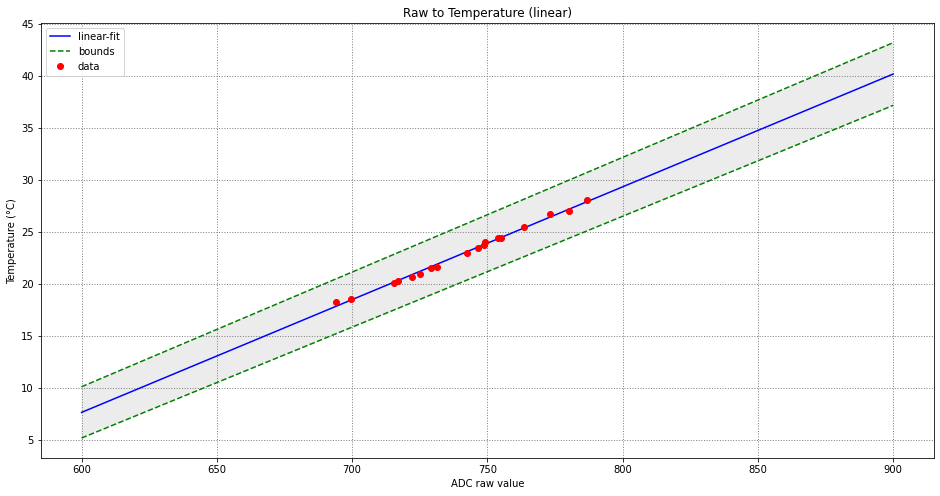

In [583]:
# linear approach
def func(x, m, b):
    return m * x + b

popt, pcov = curve_fit(linearFunc, raw, temp)
x_data = np.arange(600, 901, 10)
y_data = func(x_data, *popt)

plt.plot(x_data, y_data-273.15, 'b-', label='linear-fit')

stdevs = np.sqrt(np.diag(pcov))

upper = linearFunc(x_data, popt[0]+stdevs[0], popt[1]+stdevs[1])-273.15
lower = linearFunc(x_data, popt[0]-stdevs[0], popt[1]-stdevs[1])-273.15

plt.plot(x_data, upper, 'g--', label='bounds')
plt.plot(x_data, lower, 'g--')
plt.fill_between(x_data, upper, lower, facecolor="gray", alpha=0.15)

plt.plot(raw, temp-273.15, 'ro', label='data')
plt.rcParams['figure.figsize'] = [16,8]
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.legend();
plt.title('Raw to Temperature (linear)');
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [580]:
md("Based on linear model we get $m={:.3f} \pm {:.3f}$ and $b={:.3f} \pm {:.3f}$.".format(linParameter[0], stdevs[0], linParameter[1], stdevs[1]))

Based on linear model we get $m=0.111 \pm 0.002$ and $b=213.974 \pm 1.192$.

### Logarithmic approach

Based on 

$$ T = \frac{B \cdot T_N}{B + \ln\left( \frac{R_T}{R_N} \right) \cdot T_N} $$

and 

$$ R_T = f\left(U_2\right)$$

with


$$ R_T = $$

<ipython-input-576-e28c1aa29701>:3: RuntimeWarning: invalid value encountered in log
  return B * T_N / (B + np.log((a*x+b)/R_N)*T_N)


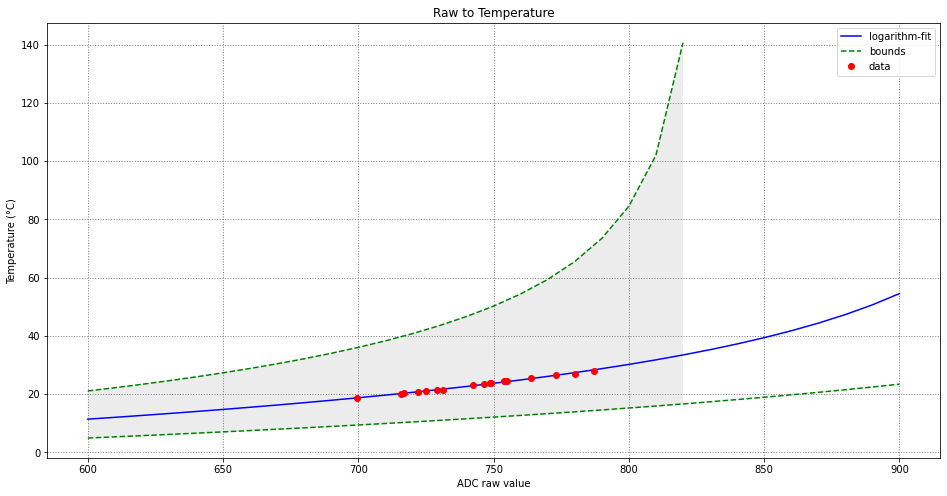

In [576]:
# logarithmic approach
def func(x, a, b):
    return B * T_N / (B + np.log((a*x+b)/R_N)*T_N)
#    return a / np.log(x/b)
#    return a * np.log(x/b+1)

popt, pcov = curve_fit(func, raw, temp, absolute_sigma=True)
x_data = np.arange(600, 901, 10)
y_data = func(x_data, *popt);

plt.plot(x_data, y_data-273.15, 'b-', label='logarithm-fit');

stdevs = np.sqrt(np.diag(pcov))

#upper = func(x_data, popt[0]+stdevs[0], popt[1]+stdevs[1], popt[2]+stdevs[2], popt[3]+stdevs[3])-273.15
#lower = func(x_data, popt[0]-stdevs[0], popt[1]-stdevs[1], popt[2]-stdevs[2], popt[3]-stdevs[3])-273.15
upper = func(x_data, popt[0]+stdevs[0], popt[1]+stdevs[1])-273.15
lower = func(x_data, popt[0]-stdevs[0], popt[1]-stdevs[1])-273.15

plt.plot(x_data, upper, 'g--', label='bounds')
plt.plot(x_data, lower, 'g--')
plt.fill_between(x_data, upper, lower, facecolor="gray", alpha=0.15)

plt.plot(raw, temp-273.15, 'ro', label='data');
plt.rcParams['figure.figsize'] = [16,8]
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.legend();
plt.title('Raw to Temperature');
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [577]:
md("Based on logarithmic model, we get $a={:.3f} \pm {:.3f}$ and $b={:.3f} \pm {:.3f}$.".format(popt[0], stdevs[0], popt[1], stdevs[1]))

Based on logarithmic model, we get $a=-4.713 \pm 0.436$ and $b=4585.580 \pm 327.003$.

## Exponential function

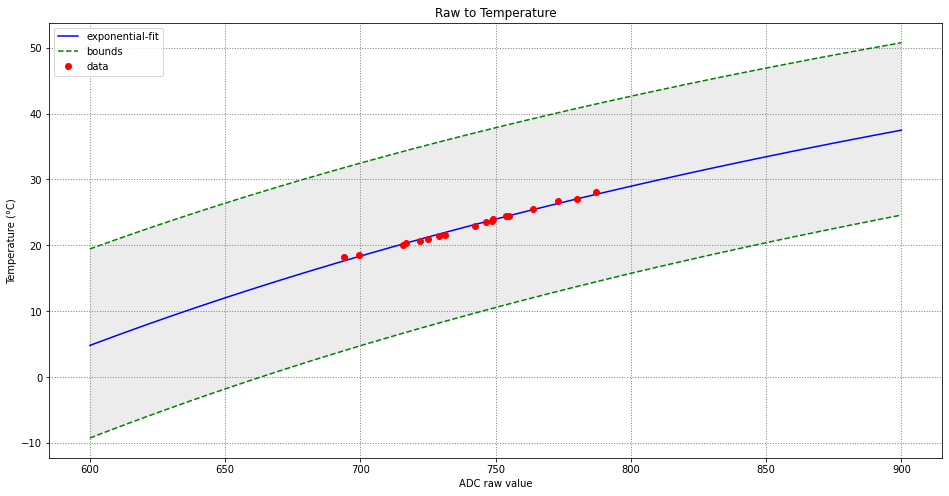

In [595]:
def func(x, a, b):
    return a*np.exp(b/x)

popt, pcov = curve_fit(func, raw, temp, absolute_sigma=True)
x_data = np.arange(600, 901, 10)
y_data = func(x_data, *popt);

plt.plot(x_data, y_data-273.15, 'b-', label='exponential-fit');

stdevs = np.sqrt(np.diag(pcov))

upper = func(x_data, popt[0]-stdevs[0], popt[1]-stdevs[1])-273.15
lower = func(x_data, popt[0]+stdevs[0], popt[1]+stdevs[1])-273.15

plt.plot(x_data, upper, 'g--', label='bounds')
plt.plot(x_data, lower, 'g--')
plt.fill_between(x_data, upper, lower, facecolor="gray", alpha=0.15)

plt.plot(raw, temp-273.15, 'ro', label='data');
plt.rcParams['figure.figsize'] = [16,8]
plt.grid(color='grey', linestyle=':', linewidth=1)

plt.legend();
plt.title('Raw to Temperature');
plt.xlabel('ADC raw value');
plt.ylabel('Temperature (°C)');

In [596]:
md("Based on logarithmic model, we get $a={:.3f} \pm {:.3f}$ and $b={:.3f} \pm {:.3f}$.".format(popt[0], stdevs[0], popt[1], stdevs[1]))

Based on logarithmic model, we get $a=387.925 \pm 8.962$ and $b=-199.969 \pm 17.092$.